Load MNIST dataset and view format

Inspired by https://sagemaker-examples.readthedocs.io/en/latest/aws_sagemaker_studio/sagemaker_algorithms/linear_learner_mnist/linear_learner_mnist.html


In [1]:
# Install libraries

import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np

In [2]:
# Import traing and test data

train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

# Show the shape of the train and test data
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

Training data shape:  (42000, 785)
Test data shape:  (28000, 784)


Reformat the data to be compatible with 28x28 pixel image inputs. 

Reset the targets to be true or false for whether the number is the target or not.

In [3]:
# Make numpy arrays of the train and test data from the pandas dataframes
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

# Show the shape of the train and test data
print('Training data shape: ', train_data.shape)
print('Test data shape: ', test_data.shape)

# Separate out the targets as the first column of the train data
train_labels = train_data[:, 0]
train_inputs = train_data[:, 1:]

# Reshape the data to be 2D arrays
train_inputs = train_inputs.reshape(-1, 28, 28)
test_inputs = test_data.reshape(-1, 28, 28)

TARGET_NUM = 5

# Reset the train labels to be 1 if it is the target number and 0 if not
train_labels = (train_labels == TARGET_NUM).astype(np.float32)

print('Training input data shape: ', train_inputs.shape)
print('Training labels data shape: ', train_labels.shape)
print('Test input data shape: ', test_inputs.shape)



Training data shape:  (42000, 785)
Test data shape:  (28000, 784)
Training input data shape:  (42000, 28, 28)
Training labels data shape:  (42000,)
Test input data shape:  (28000, 28, 28)


https://d2l.ai/chapter_convolutional-neural-networks/lenet.html#lenet

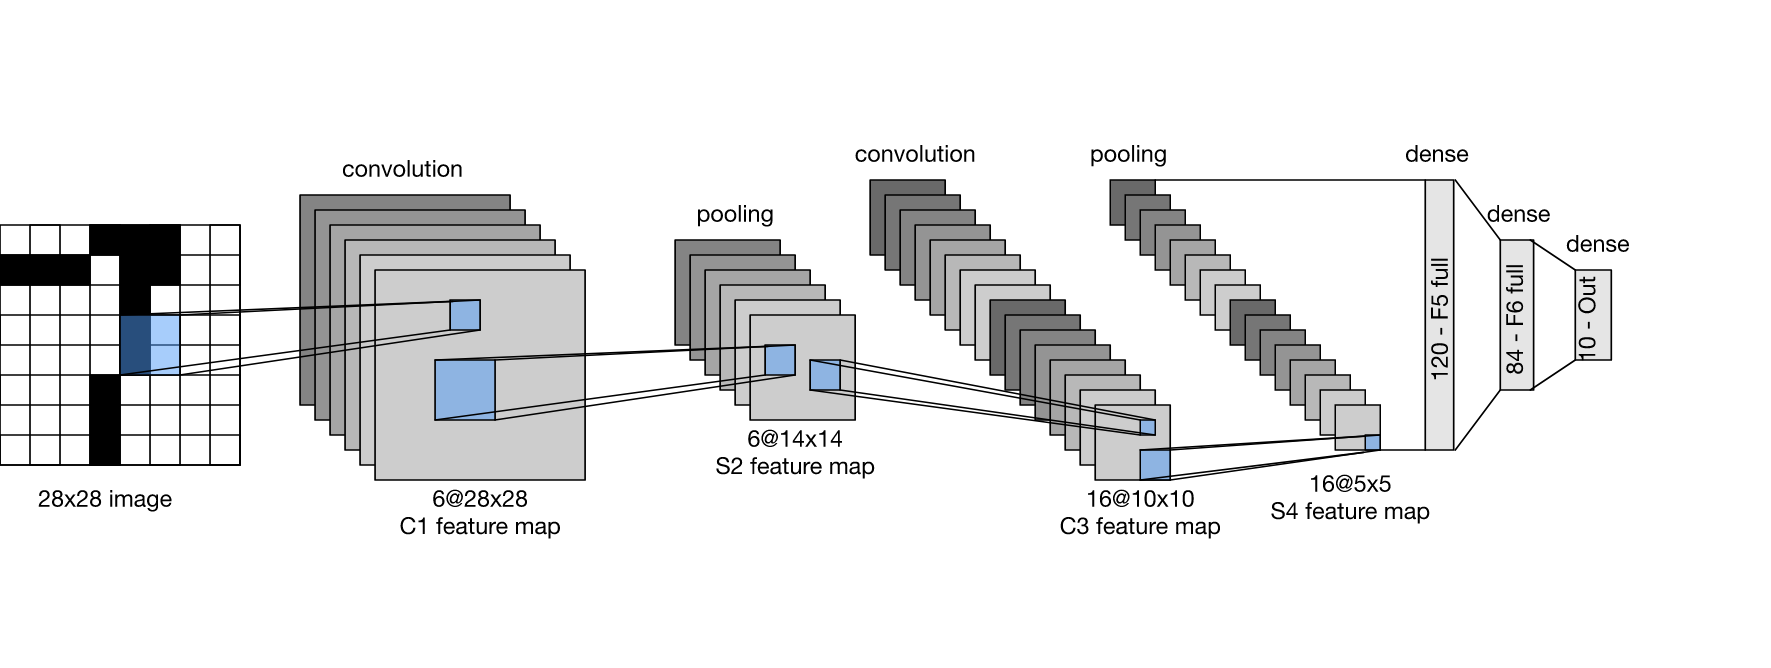

Define a basic LeNet model based on the PyTorch documentation: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
Note: Adjusted padding to be 2 to allow for inputs of 28x28 instead of 32x32.

In [6]:
class LeNet(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = LeNet()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
